# Python数值方法

In [54]:
# | code-fold: true

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set_theme() # 默认用seaborn的绘图样式

plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体。如果不设置，中文会乱码。这里采用微软雅黑'Microsoft YaHei'，如果显示不正常，也可以使用黑体'SimHei'或者宋体'SimSun'等
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']



## 插值


主要目标：把非连续观测值变成连续的。

世界上大部分的变量都是连续的，但是我们的观测肯定是离散的。比如气温，气象站可能整点（每小时）公布一次气温，那你怎么知道1点半的气温？直觉上，你可以用1点和2点的气温的平均值，作为1点半气温的估计。这就是所谓“插值”，直接求平均（或者说线性加权）的方法属于所谓“线性插值”。

另一种情况，就是时间序列数据可能有缺失，比如多年的数据中间少了1个，也可以考虑采用插值来补全。



首先构造示例数据。假定你的数据有11个离散的观测值 $x =0,1,2,3 ... 10$ ，绘制出图形：


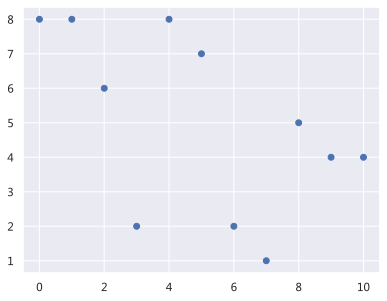

In [55]:
import matplotlib.pyplot as plt

# 数据点

np.random.seed(2)
N = 11
x = np.linspace(0, 10, N) 
y = np.random.randint(10, size=(N,)).round(3)

plt.plot(x, y, 'o');


### 一维插值

这里采用scipy中的interpolate模块，`interpolate.interp1d()`可以提供1维插值。

参数：

1. 开头2个参数是原始数据的x和y
2. `kind`参数指定插值的方法，常用的比如线性插值`linear`，二阶样条曲线`quadratic`，或者直接用前值`previous`等等。
    * 插值的方法很多，具体可见 [SciPy官网](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)。

返回值：

这个函数会根据你提供的数据以及插值的方法，返回一个新的函数`f(x)`。如果你原始数据中**只有**1点和2点的气温，那么你调用`f(1.5)`，这个函数就会告诉你它所估计1点半气温。

注意，插值的结果**一定会穿过原始数据**。


In [56]:
import numpy as np
from scipy.interpolate import interp1d

# 同样的数据，不同的插值方法可以获得不同的函数
f0 = interp1d(x, y, kind = 'linear') # 线性
f1 = interp1d(x, y, kind = 'quadratic') # 二阶样条曲线
f2 = interp1d(x, y, kind = 'previous') # 前值
f3 = interp1d(x, y, kind = 'nearest') # 最近值

虽然我们的原始数据中并没有x = 1.5的观测值，但是通过上面的这几个函数，我们可以获得x =1.5时的插值的结果。如：

In [57]:
x # 原始数据x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [58]:
f0(1.5) # 线性插值

array(7.)

In [59]:
f1(1.5) # 二次样条曲线

array(7.41522187)

我们把原始数据，和插值的结果绘制一下进行对比。显而易见，线性插值可以看成把数据点直接连起来，样条曲线插值会尽可能地平滑曲线的走势。

可以看`f0(1.5), f1(1.5)`在图上的位置。

注意，插值的结果**一定会穿过原始数据**。

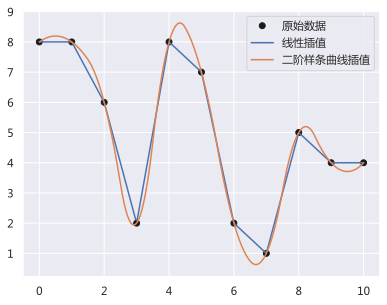

In [60]:
# 构造出密集的x，对每个x都计算函数值
new_data_x = np.linspace(0,10,200) # 把0到10切得更密集

plt.plot(x, y, 'o',c='k',label = '原始数据') # 原始数据点，黑色
plt.plot(new_data_x, f0(new_data_x), label = '线性插值') # 线性插值
plt.plot(new_data_x, f1(new_data_x), label = '二阶样条曲线插值') # 二阶样条曲线插值
plt.legend();

绘制原始数据和“最近值”和“前值”的插值结果。

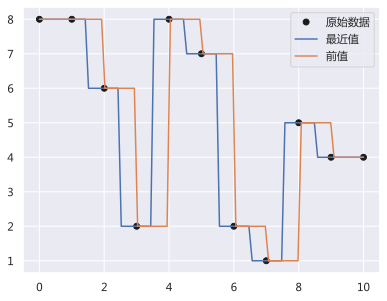

In [61]:
new_data_x = np.linspace(0,10,100)

plt.plot(x, y, 'o',c='k' ,label = '原始数据') # 原始数据点，黑色
plt.plot(new_data_x, f3(new_data_x),label = '最近值')
plt.plot(new_data_x, f2(new_data_x),label = '前值')
plt.legend();

### 单变量样条曲线

一维插值`interp1d()`有2个缺陷：

1. 不能外推，即只能补全2个端点中间的值。上例中，原始数据x的区间是0-10，那么要取`f(11)`就会出错。
2. 强制通过全部点，这对某些数据来说就没法插值了。

单变量样条曲线`UnivariateSpline()`则可以可以解决这2点，同时不要求强制通过所有点。

参数

1. `s`：s越小，则平滑的时候考虑的数据点少，曲线看起来就比较“急转弯”，`s = 0`则强制通过每一个点。默认`s = None`则用所有点进行加权，曲线会尽量“平缓地转弯”。

In [62]:
from scipy.interpolate import UnivariateSpline
g_s0 = UnivariateSpline(x,y, s = 0) # 穿过所有点
g_s3 = UnivariateSpline(x,y, s = 3) # 考虑更多的点，因此会比较平滑
g_sn = UnivariateSpline(x,y)

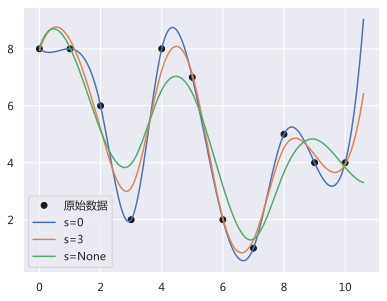

In [63]:
new_data_x = np.linspace(0,10.6,200) # 取值超过了原始数据

plt.plot(x, y, 'o',c='k',label = '原始数据') # 原始数据点，黑色
plt.plot(new_data_x, g_s0(new_data_x), label = 's=0') 
plt.plot(new_data_x, g_s3(new_data_x), label = 's=3') 
plt.plot(new_data_x, g_sn(new_data_x), label = 's=None') 
plt.legend();

注意，插值获得的函数可以取超过原始数据的x，曲线会按照“惯性”前进，见上图最右端x超过10的部分。

### 生成n阶段导数

注意，`interp1d()`和`UnivariateSpline()`，都会通过原始数据，直接返回给你一个函数`f(x)`，调用这函数就可以获得曲线上的值。

其实里面有2步骤: 1. 拟合样条曲线，把数据保存在`f(x)`中。 2. 求值。

有另一种做法，可以先获得样条曲线的数据`tck`，我们利用这个数据，除了生成`f(x)`，还可以生成其导数`f'(x)`。


1. 函数`splrep()`，接受原始数据x和y，返回样条曲线的信息`tck`。
2. 函数`splev()`，利用上一步骤生成的曲线信息`tck`，求对某个x的函数值。其中参数`der`为几阶导数，为0则为原函数。

那么一下两段代码是同一个意思：从原始数据x和y中生成过数据点的样条曲线，然后求x=1.5的函数值。
```{python}
# 代码1
f = UnivariateSpline(x,y,s=0)
f(1.5)
```

```{python}
# 代码2
tck = splrep(x,y,s=0)
splev(1.5, tck, der = 0)
```

显然两种做法曲线应该重合

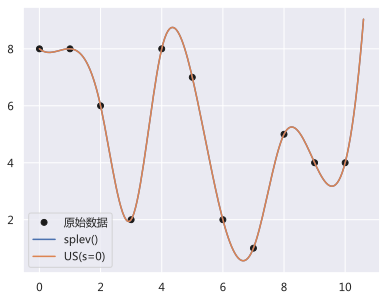

In [64]:
from scipy.interpolate import splrep, splev

# 保存样条曲线的信息到tck
tck = splrep(x,y)

plt.plot(x, y, 'o',c='k',label = '原始数据') 

# 用splev(new_data_x, tck)求数据点
plt.plot(new_data_x, splev(new_data_x, tck), label = 'splev()') 

# 用UnivariateSpline()返回的函数求数据点
plt.plot(new_data_x, g_s0(new_data_x), label = 'US(s=0)') 
plt.legend();

同样，用`splev(der = 1)`可以获得一阶导数。

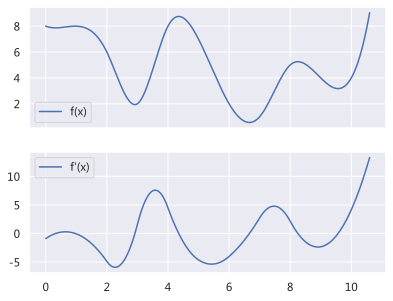

In [65]:
fig,axes = plt.subplots(2,1,sharex=True)
axes[0].plot(new_data_x, splev(new_data_x, tck, der = 0), label = 'f(x)' ) # 原始函数
axes[1].plot(new_data_x, splev(new_data_x, tck, der = 1), label = 'f\'(x)' ) # 一阶导数
axes[0].legend()
axes[1].legend();

## 凸优化（求极值）

这部分基本可以理解为“求极值”，包有约束和无约束的极值。

### 简单函数求极值

以前面随机生成的函数为例。

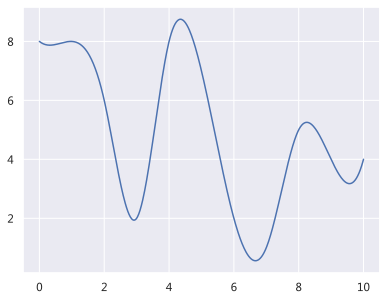

In [66]:
f = g_s0 # 上一节生成的函数

x = np.linspace(0,10,500)
y = f(x)

plt.plot(x,y);


`brute()`函数通过暴力穷举，可以求一个区间之内的函数极小值所对应的x，显然f(x)就函数的极小值。

注意这里只能求极小值，如果要求极大值，令$g(x) = -f(x)$即可。

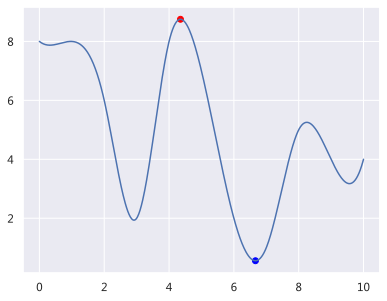

In [67]:
import scipy.optimize as sco

# 暴力求极值

# brute() 的参数： 
# 1. 要求极值的函数。 
# 2. 参数区间和间隔：2到8，间隔为0.01。注意这是一个List的List，内层的每个List对应1个参数。
# 返回值：一个列表。y的极值对应的参数，每个参数一个位置，显然这里只有1个参数。
x1 = sco.brute(f, [[2, 8, 0.01]])[0] # 利用 sco.brute，对函数f(x)，在2到8的区间内求极小值，返回极小值对应的x
y1 = f(x1)

# 把f(x)乘以-1，以此求极大值
g = lambda x: -1 * f(x)
x2 = sco.brute(g, [[2, 8, 0.01]])[0] # 获得极大值对应的x
y2 = f(x2)

# 把极大值和极小值绘制在图上
plt.plot(x,y);
plt.scatter(x1, y1, color='blue');
plt.scatter(x2, y2, color='red');

### 简单约束求极值

在约束条件下求极值：典型的就是微观经济的消费者问题：在一定的约束条件下（如收入），最大化一个函数（如效用函数）。

有两种消费品x和y，消费者具有一个CD形式的效用函数。x和y的价格为1和2，消费者的收入为m。

那么消费者的最大化问题，就可以写成：

$$
\begin{aligned}
\max \quad   u(x,y) = & x^{0.4} y^{0.6} \\

\text{s.t.} \quad      x + 2y =& m

\end{aligned}
$$

显然，我们的目标是求效用最大化的消费x和y。

先构造最小化函数 `def fun(p)`

其中，p是一个向量`(x,y)`，表示x和y的消费水平，会在函数内展开成x和y。

In [68]:
m = 10

# 先构造最小化函数
# 目标是最大化效用，因此要构造的函数应该是效用函数*(-1)
# 当这个函数取得最小值时，效用函数取得最大值
def fun(p):
    """
    要最小化的函数，即-1 * 效用函数
    """
    x,y = p # 传递进来的p是一向量(x,y)，这里展开成x和y
    return -(x**0.4 * y**0.6)


构造约束表达式

In [69]:
# 同理，构造第一个约束表达式x + 2y = m，返回值应该是0，即m-x-2y
def expend(p):
    """
    第一个约束，表达式应等于0
    """
    x,y = p
    return m - (x + 2*y)



In [70]:

# 构造参数区间，分别是x和y的区间
bnds = ((0, 10), (0, 5))

# 构造约束
# 类型：相等；约束函数是前面定义的 expend
cons = ({'type': 'eq', 'fun': expend}) # 第1个约束是等式约束，type应为'eq'

# 求极值：
# 1. 最小化函数fun
# 2. 你给出一个猜测(x=5,y=3)，函数会从这个点附近寻找最优点
# 3. 上下限
# 4. 约束函数
result = sco.minimize(fun, [5, 3],  bounds=bnds, constraints=cons)

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.365865430459912
       x: [ 4.000e+00  3.000e+00]
     nit: 6
     jac: [-3.366e-01 -6.732e-01]
    nfev: 18
    njev: 6

其中result.x，就是最优化后的2个商品消费，result.fun就是乘以-1之后的最高效用。

In [71]:
np.round(result.x, 2) # x消费4单位，y消费3单位

array([4., 3.])

In [72]:
result['fun'] * (-1) # 最优效用

3.365865430459912

In [73]:
expend(result.x).round(2) # 钱全部花完

0.0

如果多加一个约束，例如x是配给供应，最多消费3单位，那么问题就是：(现在不要求钱花完)

$$
\begin{aligned}
\max \quad  u(x,y) = & x^{0.4} y^{0.6} \\

\text{s.t.} \quad      x + 2y \leq & m \\

x \leq & 3

\end{aligned}
$$


In [74]:
def xlim(p):
    """
    第一个约束，这里的表达式应大于0；
    x <= 3，对应3 - x >= 0
    """
    x,y = p
    return 3 - x

cons = ({'type': 'ineq', 'fun': expend}, # 第1个约束是不等式约束，type应为'ineq'
        {'type': 'ineq', 'fun': xlim})   # 第2个约束是不等式约束，type应为'ineq'

# 求极值，其他参数类似
result = sco.minimize(fun, [5, 3],  bounds=bnds, constraints=cons)

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.290707859718669
       x: [ 3.000e+00  3.500e+00]
     nit: 2
     jac: [-4.388e-01 -5.641e-01]
    nfev: 6
    njev: 2

配给制下，最大化效用下降了。

In [75]:
expend(result.x).round(2) # 钱全部花完

0.0

## 解方程(组)

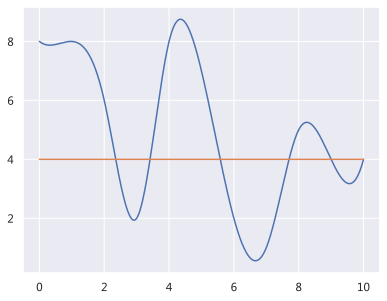

In [76]:
f = g_s0 # 上一节生成的函数

x = np.linspace(0,10,500)
y = f(x)

plt.plot(x,y);
plt.plot([0,10],[4,4])

解这个函数：`f(x) - 4 = 0`。


fsolve可以用于解方程：

1. 第1个参数：要解的函数，必须是等于0的形式
2. 第2个参数：你对解的猜测，fsolve会在你的猜测的附近进行搜索

注意：fsolve非常依赖于你的猜测，最好不要猜得太远，否则会找不到。

In [77]:
g = lambda x: f(x) - 4 # g(x) = f(x) - 4

result = sco.fsolve(g ,[2.5, 3.5, 5, 7])
result 

array([2.35408601, 3.41291772, 5.58018654, 7.70212142])

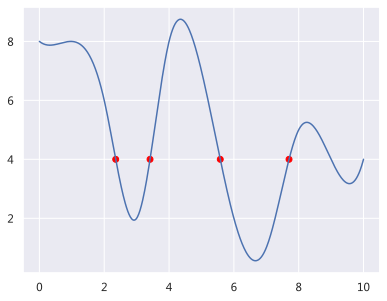

In [78]:
x = np.linspace(0,10,500)
y = f(x)

plt.plot(x,y)
plt.scatter(result,f(result),color='red');

显然，fsolve只会找到我们的猜测值附近的解。

方程组也是类似：

如2个方程解2个未知数

\begin{cases}
1 + y - (x-1)^2 = 0\\
2(x+5) - y = 0
\end{cases}


因为本案的y很容易解出来，所以比较容易绘图。但很多函数的y不能解出表达式 y = ...，因此未必能绘图。

显然，让上面的方程组同时成立，必然是2个曲线的交点。

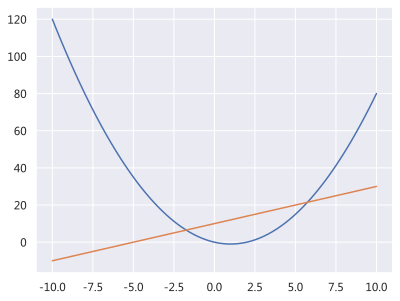

In [79]:
def f(x):
    return (x-1)**2 - 1 

def g(x):
    return 2*(x+5)

x = np.linspace(-10,10,100)

plt.plot(x,f(x))
plt.plot(x,g(x));

解为(x,y)的形式，x和y会让前面的方程组成立（结果等于0）,就是我们要的解。

In [80]:
def equ(p): 
    x, y = p # p即 (x,y)

    # 两个方程，必须是等于0的形式
    eq1 = 1 + y - (x-1)**2 
    eq2 = 2*(x+5) - y
    return eq1, eq2

# 第2个参数依然是你的最佳猜测，解的形式是(x,y)，显然你也要采使方程组成立的(x,y)
result1 = sco.fsolve(equ,(-2.5,5))
result1
# 结果中包含了需要的(x,y)

result2 = sco.fsolve(equ,(5,20))
result2


array([ 5.74165739, 21.48331477])

result1和result2就是方程组的2个解。绘制成图形，则正好是2个交点。

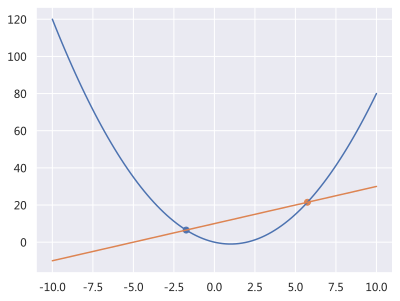

In [81]:
plt.plot(x,f(x))
plt.plot(x,g(x));
plt.scatter(result1[0],result1[1])
plt.scatter(result2[0],result2[1])

## 小练习

假设你有一组关于某个函数 $f(x)$ 的数据点 $(x,y)$ 如下 ：  
$$
(0, 1), (1, 2.1), (2, 4.2), (3, 8.1), (4, 16.3)
$$

这些数据点表示了某个未知函数 \( f(x) \) 的值。现在，你需要完成以下三个任务：

1. 使用插值法估算 $f(2.5)$ 的值。

2. 求出函数 $f(x) = 2^x$ 在区间 [0, 4] 上的极值。

3. 解方程 $2^x = 10$，求出 $x$ 的解。

